In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
np.random.seed(42)

X_normal = np.random.normal(loc=0, scale=1, size=(1000, 2))

X_anom = np.random.uniform(low=-6, high=6, size=(50, 2))

X = np.vstack([X_normal, X_anom])
y = np.hstack([np.zeros(len(X_normal)), np.ones(len(X_anom))])

In [16]:
X.shape

(1050, 2)

In [17]:
y.shape

(1050,)

<function matplotlib.pyplot.show(close=None, block=None)>

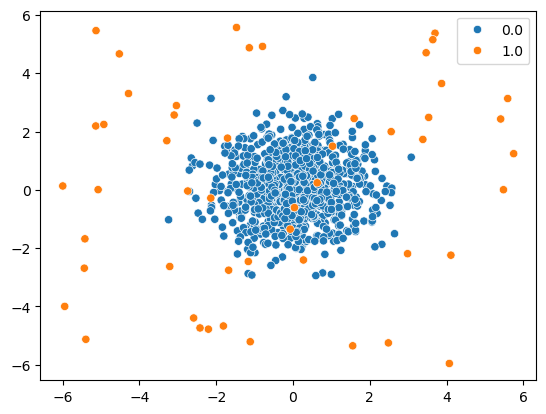

In [29]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
plt.show

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import IsolationForest

In [31]:
X_train, X_test_norm = train_test_split(X_normal, test_size=0.3, random_state=42)
X_test = np.vstack([X_test_norm, X_anom])
y_test = np.hstack([np.zeros(len(X_test_norm)), np.ones(len(X_anom))])

In [32]:
X_train.shape, X_test_norm.shape, X_test.shape, y_test.shape

((700, 2), (300, 2), (350, 2), (350,))

In [33]:
iso = IsolationForest(n_estimators=300, contamination=0.05, random_state=42)

iso.fit(X_train)

,n_estimators,300
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [38]:
normality_score = iso.decision_function(X_test)
anomaly_score = -normality_score

In [39]:
raw_pred = iso.predict(X_test)
y_pred = (raw_pred == -1).astype(int)

In [41]:
print(classification_report(y_test, y_pred, target_names=['normal', 'anomaly']))

              precision    recall  f1-score   support

      normal       0.99      0.94      0.96       300
     anomaly       0.72      0.92      0.81        50

    accuracy                           0.94       350
   macro avg       0.85      0.93      0.88       350
weighted avg       0.95      0.94      0.94       350



In [42]:
auc = roc_auc_score(y_test, anomaly_score)
print("ROC AUC:", auc)

ROC AUC: 0.9477333333333333


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

In [63]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)

In [64]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

        self.decoder = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
model = Autoencoder()
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [65]:
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

In [66]:
epochs = 1000

for epoch in range(epochs):
    model.train()

    x_hat = model(X_train_t)
    loss = criterion(x_hat, X_train_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train loss: {loss.item():.6f}")

model.eval()
with torch.inference_mode():
    X_test_hat = model(X_test_t)

    test_error = torch.mean((X_test_hat - X_test_t) ** 2, dim=1)

    X_train_hat = model(X_train_t)
    train_error = torch.mean((X_train_hat - X_train_t) ** 2, dim=1)


Epoch 20/1000 | Train loss: 1.131661
Epoch 40/1000 | Train loss: 1.057976
Epoch 60/1000 | Train loss: 0.994899
Epoch 80/1000 | Train loss: 0.936411
Epoch 100/1000 | Train loss: 0.876692
Epoch 120/1000 | Train loss: 0.810945
Epoch 140/1000 | Train loss: 0.740090
Epoch 160/1000 | Train loss: 0.670386
Epoch 180/1000 | Train loss: 0.610953
Epoch 200/1000 | Train loss: 0.570537
Epoch 220/1000 | Train loss: 0.544001
Epoch 240/1000 | Train loss: 0.524815
Epoch 260/1000 | Train loss: 0.510517
Epoch 280/1000 | Train loss: 0.499802
Epoch 300/1000 | Train loss: 0.491870
Epoch 320/1000 | Train loss: 0.486011
Epoch 340/1000 | Train loss: 0.481679
Epoch 360/1000 | Train loss: 0.478295
Epoch 380/1000 | Train loss: 0.475457
Epoch 400/1000 | Train loss: 0.472787
Epoch 420/1000 | Train loss: 0.470294
Epoch 440/1000 | Train loss: 0.467853
Epoch 460/1000 | Train loss: 0.465420
Epoch 480/1000 | Train loss: 0.462910
Epoch 500/1000 | Train loss: 0.460386
Epoch 520/1000 | Train loss: 0.457807
Epoch 540/1000 |

In [67]:
threshold = np.percentile(train_error.numpy(), 95)

y_pred_ae = (test_error.numpy() > threshold).astype(int)

In [68]:
print(classification_report(y_test, y_pred_ae, target_names=["normal", "anomaly"]))
print("ROC AUC:", roc_auc_score(y_test, test_error.numpy()))

              precision    recall  f1-score   support

      normal       0.96      0.94      0.95       300
     anomaly       0.67      0.74      0.70        50

    accuracy                           0.91       350
   macro avg       0.81      0.84      0.83       350
weighted avg       0.92      0.91      0.91       350

ROC AUC: 0.9204666666666667
